In [ ]:
# Place all your imports in a separate cell.  
# Imports can sometimes take time to execute.
from __future__ import annotations
import os
import json
import re
import getpass
import requests
from datetime import datetime
from typing import TypedDict, List, Optional
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image
from langgraph.graph import StateGraph, END
from langchain_tavily import TavilySearch
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain.schema import Document

In [ ]:
load_dotenv("access.env")

def get_env_or_prompt(var: str, prompt: str) -> str: # loading or taking environmental variables
    val = os.getenv(var)
    if not val:
        val = getpass.getpass(prompt)
        os.environ[var] = val
    return val

# load Gemma model name + local host address from access.env file
MODEL = get_env_or_prompt("Gemma_model_name", "Enter model name: ") 
URL   = get_env_or_prompt("gemma_URL", "Enter model URL (/api/chat): ")
HEADERS = {"Content-Type": "application/json"}

# English system prompt (but responses must be Persian) 
# NOTE: Best practice is to give your instructions in English, as LLMs are trained on large English datasets
SYSTEM_PERSIAN_ONLY = (
    "You are a clinical decision-support assistant. "
    "Follow all developer instructions exactly. " 
    "IMPORTANT: Provide all responses in Persian (Farsi) only."
)

FIVE_ONLY_INSTRUCTIONS_EN = (
    "Produce 3–5 Persian bullets, each 1–3 sentences long, factual and self-contained. "
    "Each bullet must state a distinct, evidence-supported point drawn from the provided context. "
    "Do NOT add introductory or concluding text, numbering, headings, or citations—only the bullets, one per line. "

)

STRICT_EVIDENCE_RULES_EN = (
    "- Use ONLY the retrieved notes as evidence.\n"
    "- If the notes already cover the answer but need a tiny logical bridge, you may add at most ONE very short, generic bridging sentence, Try to use your own knowledge beside documents "
    "(no new facts, numbers, doses, percentages, drug names, or fresh claims).\n"
    "- Never invent or interpolate numbers, drug doses, percentages, timelines, contraindications, or treatments that are not present in the notes.\n"
    "- If the notes conflict, briefly acknowledge the uncertainty and reflect the most cautious statement that appears in the notes.\n"
)

MEDICAL_DOCTOR_PROMPT_EN = (
    "You are a professional medical assistant for clinicians.\n"
    "If you're going to advise the user to see a doctor, do this only once (AND ONLY ONCE), No more than one time."
    "Answer ONLY medical questions, and write your answer in Persian (Farsi). "
    "If the question is non-medical, reply politely in Persian: «این پرسش در حوزهٔ پزشکی نیست؛ لطفاً سؤال پزشکی بپرسید.»\n\n"

    "RULES:\n"
    "1) Evidence scope:\n"
    f"{STRICT_EVIDENCE_RULES_EN}\n"

    "2) Length & format:\n"
    "- Write a single cohesive paragraph in Persian.\n"
    "- Minimum 70 words; target 90–130 words. You may exceed 130 if needed for safety/clarity, but never go below 70.\n"
    "- Do not use bullet points, headings, links, or source names unless the user explicitly asks.\n\n"

    "3) Style & tone:\n"
    "- Clear, precise, clinically useful, friendly and professional.\n"
    "- Avoid hedging and verbosity; explain technical terms briefly in parentheses when helpful.\n\n"

    "4) Safety:\n"
    "- Do not add numbers, doses, percentages, timelines, zor contraindications beyond what is in the notes.\n"
    "- If the notes include specific red-flag/urgent signs, add one short closing sentence about the appropriate action; "
    "otherwise avoid generic warnings.\n\n"

    "5) No process talk:\n"
    "- Do not mention searches, retrieved documents, or your reasoning process—present only the medical content, Don't inform user that there is a retrieved info for you.\n\n"


    "6) Adaptation:\n"
    "- If the user requests, adapt complexity to their level, but never exceed the evidence contained in the notes.\n"
)


# Chorma vector store (light weight + multiligual for Persian RAG)
EMBEDDING = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
)

# initialize vector store
def get_chroma_store() -> Chroma: 
    print("[store] opening Chroma collection...")
    return Chroma(
        collection_name="Agentic_AI_event_collection", # Just assigning it a name
        embedding_function=EMBEDDING,
        persist_directory="./chroma_langchain_db", # Tries to re-load previously-created vector store (if exists) for efficiency and speed.
    )

# cleans and normalizes generated text (mainly for parsing the response that comes from LLM) | result: a clean human-readable text
def clean_text(text: str) -> str:
    text = re.sub(r"\s+([,\.!?;:])", r"\1", text) # Finds extra spaces and remove those
    text = re.sub(r"([\.!?])([^\s])", r"\1 \2", text) # Ensures there’s a space after punctuation if it’s missing.
    return re.sub(r"\s+", " ", text).strip() # collapses multiple spaces/tabs/newlines into a single space. Removes leading/trailing whitespace.

# converts any input (dict, object, or string) into a standard message dictionary for the LLM (formats the text for the LLM to be readable)
def normalize(msg) -> dict:
    if isinstance(msg, dict):
        role = msg.get("role") or "user"
        content = msg.get("content", "")
    else:
        role = getattr(msg, "role", None) or getattr(msg, "type", None) or "user"
        content = getattr(msg, "content", None) or str(msg)
    role = str(role).lower()
    if role == "human":
        role = "user"
    if not role or role == "unknown":
        role = "user"
    return {"role": role, "content": str(content)}

# Handles and shows any http or request error coming from the server
def handle_http_error(resp: Optional[requests.Response]) -> str:
    messages = {
        400: "Bad request:\nPlease check your input.",
        401: "Unauthorized:\nInvalid API key.",
        403: "Forbidden:\nAccess is denied.",
        404: "Not found.",
        502: "Bad gateway:\nInvalid response from the server.",
        503: "Service unavailable:\nServer is down.",
        504: "Gateway timeout:\nNo response from the server.",
    }
    code = getattr(resp, "status_code", None)
    msg = messages.get(code, f"HTTP Error: {code}" if code else "Server Error")
    print(f"[FATAL] {msg}")
    return msg

# initialize and call local LLM with relevant parameters + history that will be sent to the LLM each time
def call_llm(messages: List[dict]) -> dict:
    history = [normalize(m) for m in messages]
    sys_msg = {"role": "system", "content": SYSTEM_PERSIAN_ONLY}
    payload = {
        "model": MODEL,
        "messages": [sys_msg] + history,
        "stream": True,
        "think": False,  # prevent explicit chain-of-thought emissions
    }

    full = ""
    resp = None
    print("[llm] streaming...")
    with requests.post(URL, headers=HEADERS, json=payload, stream=True, timeout=90) as resp:
        resp.raise_for_status()
        for line in resp.iter_lines():
            if not line:
                continue
            try:
                data = json.loads(line.decode())
            except json.JSONDecodeError:
                continue
            if isinstance(data.get("message"), dict):
                chunk = data["message"].get("content", "")
                if chunk:
                    full += chunk
            if data.get("done"):
                break

    # strip any stray <think> blocks if present 
    full = re.sub(r"<think>.*?</think>", "", full, flags=re.DOTALL) 
    return {"role": "assistant", "content": clean_text(full)} # showing what the LLM says 

# getting the actual response of LLM by assigning it another "user" field ("assistant" role is already assigned in "call_llm" function)
def llm_generate(text_prompt: str) -> str: 
    out = call_llm([{"role": "user", "content": text_prompt}])
    return out.get("content", "").strip() 

# defining the flow of the data, LangGraph state, datatypes
class QAState(TypedDict, total=False):
    question: str # user prompt
    system_prompt: str # system prompt passed to LLM 
    non_medical_reply: str # check if question is non-medical
    idx: int # for indexing
    retrieved_docs: List[str] # retrieved documents from vector store
    retrieval_scores: List[float]  # kept for compatibility (not used): [for developer] -> this part is for an older code version
    tavily_raw: str # The non-parsed tavily responses to queries
    tavily_answer: str # an specific field called "answer" from Taily resonse will be processed later
    five_answers: List[str] # five chunks that will be saved in vector store 
    final_answer: str # The parsed LLM's response to the "question"
    is_medical: bool # accepts if the "question" is medical or not, if medical "True", else "False"
    did_fallback: bool # accepts if fallback is taken
    fallback_attempts: int # determines how many times fallback happened

# Aanlyzes the question, if question is medical-related returns "True", else "False"  
def ensure_medical_question(user_query: str) -> bool:
    #NOTE: despite Persian-only system message, we explicitly request English tokens here (best practice of prompt engineering).
    print("[classifier] Evaluating user's question...") 
    prompt = (
        "You are a strict classifier. Decide whether the query is MEDICAL or NON_MEDICAL. "
        "Return EXACTLY ONE uppercase English token: MEDICAL or NON_MEDICAL. "
        "Do not add any text.\n\n"
        f"Query:\n{user_query}"
    )
    out = llm_generate(prompt).upper().strip()
    is_med = out == "MEDICAL"
    print(f"[classifier] result = {out}")
    return is_med

# Chunking of the text will be done by our LLM (Agentic chunking😎) -> five chunks (most related to question) will be produced
def llm_make_five(question: str, context: str) -> List[str]: 
    print("[five] generating five short Persian answers... ")
    prompt = (
        f"{MEDICAL_DOCTOR_PROMPT_EN}\n"
        f"{FIVE_ONLY_INSTRUCTIONS_EN}\n\n"
        f"Question:\n{question}\n\n" 
        f"Context (web snippets or summary):\n{context}\n"
    )
    txt = llm_generate(prompt) 
    lines = [l.strip("-• \t") for l in txt.splitlines() if l.strip()] # txt.splitlines() —> splits the LLM’s multi-line output (the full text) into individual lines wherever there’s a newline character | for l in txt.splitlines() if l.strip() -> filters out empty lines
    # Remove exact duplicates 
    seen, uniq = set(), [] # seen: keeps track of what has already appeared, uniq: stores the cleaned, unique answers in order. 

    # logic: If it’s not already in seen, add it to both seen and uniq. If it’s already in seen, it’s a duplicate → skip it.
    for s in lines:
        if s not in seen:
            seen.add(s)
            uniq.append(s)
    print(f"[five] produced {len(uniq)} unique lines.") # counts how many unique lines were produced
    return uniq[:5] # returns only the first 5 answers (if the model produced more).

# providing our LLM with retrieved documents(3 docs) + providing instructions on how to give the response to user
def llm_final_from_retrieval(user_query: str, top3: List[str]) -> str:
    print("[final] synthesizing from retrieved docs...")
    joined = "\n\n---\n\n".join(top3)
    prompt = (
        f"{MEDICAL_DOCTOR_PROMPT_EN}\n"
        "IMPORTANT: Use ONLY the following retrieved notes. "
        "If the notes do not contain the answer, reply with: «پاسخی یافت نشد».\n\n"
        f"USER QUERY:\n{user_query}\n\n"
        f"RETRIEVED (3 docs):\n{joined}\n\n"
        "Answer clearly in Persian and keep it concise."
    )
    return llm_generate(prompt)


# NODES 
# classifies if the "question" is medical (True) or non-medical (False)
def classifier_node(state: QAState) -> QAState: 
    is_med = ensure_medical_question(state["question"]) 
    state["is_medical"] = is_med 
    if not is_med: # if is_medical == False
        friendly = state.get("non_medical_reply") or "این پرسش در حوزه پزشکی نیست؛ لطفاً سؤال پزشکی بپرسید."
        state["final_answer"] = friendly
        print("[classifier] non-medical → prepared friendly Persian reply.")
    return state

# Gets and sorts the chunks(retrieved text)
def _text_from_doc(doc) -> str:
    if hasattr(doc, "page_content"): # if document has ".page_conent" attribute..
        return doc.page_content # return document with (represents the main content area of a webpage, containing the primary text, images, and other elements that convey the core information)
    if isinstance(doc, dict) and "page_content" in doc: # if the type of "doc" is a dictionary and contains "page content"
        return doc["page_content"] # all qualified to be returned
    return str(doc) # else, return only the string of returned document (last resort)

# retrieval process (retrieves 3 related chunks)
def query_vector_store_top3_node(state: QAState) -> QAState:
    print("[top3] retrieving top-3...") 
    store = get_chroma_store() # loads vector stroe
    query = state["question"] # user query
    results = store.similarity_search(query, k=3)  # retrieve 3 closest chunks related to "question"
    texts = [_text_from_doc(doc) for doc in results] # all retrieved chunks returned back to us in a NEAT way 
    state["retrieved_docs"] = texts # 3 related chunks per each question
    state["retrieval_scores"] = []  # not used 
    if texts: # if texts existed
        print("[top3] 3 related docs were retrieved")
    #     for i, t in enumerate(texts, 1): # Indexed returned chuks will be shown to you
    #         print(f"  {i}. {t[:80]!r}") # the shown chunks
    # else:
    #     print("[top3] no relevant docs → fallback will trigger.")
    return state

def final_answer_from_retrieval_node(state: QAState) -> QAState:
    docs = state.get("retrieved_docs", []) # all retrieved content from vector store will be returned back
    docs = sorted(docs, key=lambda d: len(d), reverse=True) # prefer longer or newer docs
    top3 = docs[:3]
    if top3:
        ans = llm_final_from_retrieval(state["question"], top3) # passing our LLM the retrieved docs + user query
        if "پاسخی یافت نشد" in ans or len(ans.strip()) < 20: 
            print("[final] weak answer → trigger fallback ingestion")
            state = fallback_ingest_node(state) # A fallback for the cases where the question isn't found in vector store (it does the pipeline from scratch)
            # re-retrieve after fallback 
            state = query_vector_store_top3_node(state)
            if state.get("retrieved_docs"):
                ans = llm_final_from_retrieval(state["question"], state["retrieved_docs"][:3])
        state["final_answer"] = ans # Newly answered query 
    else:
        print("[final] no docs available, skipping to fallback.")
        state = fallback_ingest_node(state)
        state["final_answer"] = "پاسخی یافت نشد."
    return state


# Fallback ingestion 
# Gets the best answer from Tabily (web scrapping utility)
def parse_tavily_answer(tavily_dict: dict) -> str:  
    if not isinstance(tavily_dict, dict): # if tavily didn't return a dictionary response... 
        return str(tavily_dict) # return the string
    if tavily_dict.get("answer"): # if tavily serach results contains "answer" field:
        return tavily_dict["answer"] 
    results = tavily_dict.get("results") or [] 
    if results:
        r0 = results[0] 
        for key in ("raw_content", "content", "title", "url"):
            val = r0.get(key) # getting the first element of "answer"
            if val:
                return val
    return json.dumps(tavily_dict, ensure_ascii=False) # ensure_ascii=False: ensures non-latin characters are acceptible

# Get Tavily to search search
def tavily_search_node(state: QAState) -> QAState:
    print("[fallback] running Tavily search...")
    q = state["question"]
    tavily = TavilySearch(
        max_results=3,
        topic="general",
        include_raw_content=True,
        include_answer="advanced",
        search_depth="advanced",
        time_range="year",
        include_images=False,
        include_image_descriptions=False,
        include_favicon=False,
    )
    tavily_dict = tavily.run(q)
    state["tavily_raw"] = json.dumps(tavily_dict, ensure_ascii=False)
    state["tavily_answer"] = parse_tavily_answer(tavily_dict)
    print("[fallback] Tavily answer parsed.")
    return state

# saves the "question" and tavily search result to a txt file for fallback and ensuring things
def save_tavily_to_file_node(state: QAState) -> QAState:
    print("[fallback] appending to answers.txt ...")
    line = f"{state.get('idx', 0)}- {state['question']}: {state['tavily_answer']}\n"
    with open("answers.txt", "a", encoding="utf-8") as f:
        f.write(line)
    print("[fallback] one line saved to answers.txt")
    return state

# passing user query("question") + tavily search results to get the most suitable chunks
def llm_make_five_node(state: QAState) -> QAState:
    q = state["question"]
    raw = state.get("tavily_raw", "")
    ctx = f"{state.get('tavily_answer', '')}\n\n{raw[:2000]}"  # use first ~2000 chars | ctx = context
    five = llm_make_five(q, ctx) # question and context by Tavily passed to LLM
    state["five_answers"] = five
    return state

# saving newly taken answers to vector store
def add_five_to_vector_store_node(state: QAState) -> QAState:
    print("[fallback] adding five answers to vector store...")
    store = get_chroma_store()
    answers = state.get("five_answers", [])
    docs = [
        Document(page_content=ans, metadata={"question": state["question"], "variant": i + 1}) # formatting chunks to fit into vector store | questions and indices are saved as metadata
        for i, ans in enumerate(answers) 
        if ans.strip()
    ]
    if docs:
        store.add_documents(docs) # adding stage
        print(f"[fallback] added {len(docs)} docs.")
    else:
        print("[fallback] nothing to add.")
    return state

# if the answer to question is not found, this fallback will be triggered (most steps covered in above functions)
def fallback_ingest_node(state: QAState) -> QAState:
    tries = int(state.get("fallback_attempts", 0))
    state["fallback_attempts"] = tries + 1
    state["did_fallback"] = True
    print(f"[fallback] attempt #{state['fallback_attempts']}")
    state = tavily_search_node(state)
    state = save_tavily_to_file_node(state)
    state = llm_make_five_node(state)
    state = add_five_to_vector_store_node(state)
    print("[fallback] ingestion pass complete.")
    return state

# determines how the step after calssifier will do 
def route_after_classifier(state: QAState) -> str:
    return "Start_retrieval" if state.get("is_medical") else "Reject" # if "is_medical" == True, retrieve chunks and continue the process, else reject the question

# thoroughly checking vector store for qualified answers, if not, we will give up answering
def route_after_top3(state: QAState) -> str:
    has_docs = bool(state.get("retrieved_docs")) # checks if there is any chunks is accessible for 
    if has_docs:
        return "Information_found" 
    tried = int(state.get("fallback_attempts", 0)) 
    if tried < 1: # If fallback hasn't triggered yet, trigger the fallback 
        print("[router] no docs → Use_alternative")
        return "Use_alternative"
    print("[router] no docs after fallback → No_proper_answer_found")
    state["final_answer"] = (
        "در حال حاضر منبع کافی پیدا نشد. "
        "می‌خواهید جست‌وجو را گسترده‌تر انجام دهم یا سؤال را دقیق‌تر بیان کنید؟"
    )
    return "No_proper_answer_found"

# performas as history, each conversation will be appended to a JSONL file  
def log_interaction_to_jsonl(state: QAState, answer: str, filename: str = "conversation_history.jsonl"):
    record = {
        "timestamp": datetime.now().isoformat(), # also saves data and time
        "question": state.get("question"),
        "answer": answer,
        "is_medical": state.get("is_medical"),
        "did_fallback": state.get("did_fallback"),
        "retrieved_docs": state.get("retrieved_docs", []),
        "fallback_attempts": state.get("fallback_attempts", 0),
    }
    try:
        with open(filename, "a", encoding="utf-8") as f:
            f.write(json.dumps(record, ensure_ascii=False) + "\n")
    except Exception as e:
        print(f"[log] Failed to write log: {e}")

agent = StateGraph(QAState) 
# Assigning a name for each function (node)
agent.add_node("Evaluating_the_question", classifier_node)
agent.add_node("Searching_internal_memory", query_vector_store_top3_node)
agent.add_node("Final_answer", final_answer_from_retrieval_node)
agent.add_node("Web_search", fallback_ingest_node)

agent.set_entry_point("Evaluating_the_question") # starting point of our Graph

agent.add_conditional_edges( # conditional edge: this is not an straight edge, can be flexible and change based on the "condtions"
    "Evaluating_the_question", 
    route_after_classifier, # if "route_after_classifier" returns "is_medical", "go retrieve" will be triggered, else we will reject the question
    {"Start_retrieval": "Searching_internal_memory", "Reject": END}, 
) 

agent.add_conditional_edges( 
    "Searching_internal_memory",
    route_after_top3, 

    # if "have docs", give the answer and reach "final" | if "do fallback", trigger "fallback_ingest" | if "give up", end the pipeline
    {"Information_found": "Final_answer", "Use_alternative": "Web_search", "No_proper_answer_found": END},
)
agent.add_edge("Web_search", "Searching_internal_memory") # this IS an straight edge -> if "fallback_ingest", send information to "top3" (and top 3 will do the rest)
agent.add_edge("Final_answer", END) # "final" will answer the question and ends the pipeline

agent_app = agent.compile() # commands: Hey, run my pipeline


def agentic_answer( 
    user_query: str,
    system_prompt: Optional[str] = MEDICAL_DOCTOR_PROMPT_EN,
    non_medical_reply: Optional[str] = "این پرسش در حوزه پزشکی نیست؛ لطفاً سؤال پزشکی بپرسید.",
) -> str:
    print(f"[input] {user_query}")
    state: QAState = {
        "question": user_query,
        "system_prompt": system_prompt,
        "non_medical_reply": non_medical_reply, 
    }
    out = agent_app.invoke(state) # out == all states up to now
    answer = out.get("Final_answer", "").strip()
    if re.search(r"پاسخ.?یافت.?نشد", answer) or len(answer) < 20:
        print("[agentic] initial attempt failed → triggering fallback manually...")
        out = fallback_ingest_node(out)
        out = query_vector_store_top3_node(out)
        answer = llm_final_from_retrieval(out["question"], out.get("retrieved_docs", [])[:3]) # state.get["final_answer"]
    print("[done] final answer prepared.")
    try:
        display(Markdown(f"**پرسش:** {user_query}\n\n**پاسخ:**\n\n{answer}")) # display(markdown) -> suitable for Jupyter notebook
    except Exception:
        pass
    log_interaction_to_jsonl(out, answer) #saving to log
    return answer 



In [ ]:
# Getting pipeline's response to our query:
while True:
    x = input("Dr.Agentic is at your serve: ") 
    if x == "q": 
        break 
    else:
        agentic_answer(x)

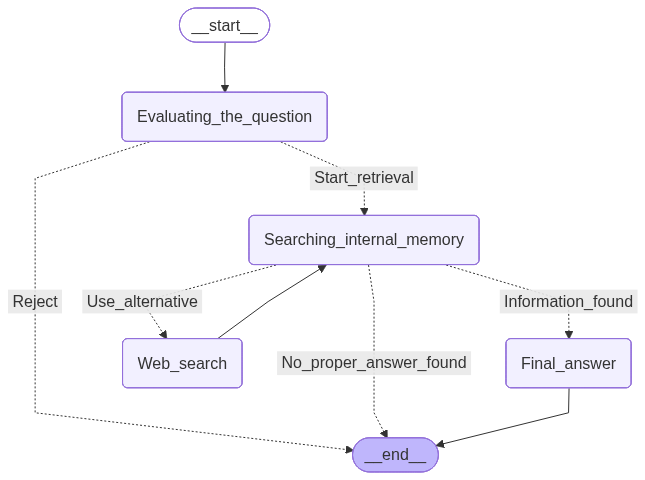

In [6]:

# part of getting the graph of the code 
display(Image(agent_app.get_graph().draw_mermaid_png())) 